## Loop to get the Spatial Structure Parameters

In [1]:
using PyCall

using Distributions, Statistics, Distances
using DataFrames
using LightGraphs, SimpleWeightedGraphs
using Random , Printf, Glob

import PyPlot , CSV
import Distances, StatsBase

rootdir = "/home/stephane/Science/cluster/GAIA"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

## directory
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/plotdens"
ocdir= "$wdir/oc2"

cd(wdir)

In [2]:
cd(ocdir)
files= glob("*-oc.csv")
cd(wdir)

df = DataFrame(voname= String[], C= Float64[], Cerr= Float64[], s= Float64[], serr= Float64[], m= Float64[],
merr= Float64[])

fitflag= true
noc= 0 ; nfail= 0

for f in files
    if fitflag
        fname= f[1:end-4] ; fvot= f[1:end-7]
        oc= CSV.read("$ocdir/$fname.csv" , delim= ";")
        ocfile= "$ocdir/$fname.csv" ; voname= "$fvot.vot"
        println("## ocfile: $voname")
        println("## fitting the radial profile....")
    
        ntest= 200 ; niter= 100000 ; nburnin= 30000
    
        ## estimating the binning
        nstar= length(oc.X)
        println("## Nstar: $nstar")
        nbin= min(trunc(Int, nstar/10),20)
        println("## NBIN: $nbin")
    
        verbose= false
        θfit, θfiterr, fitfound= spatialParameter(ocfile, ntest, nbin, niter, verbose, nburnin)
    
        println("## Fit:")
        println(θfit)
        println(θfiterr)
        println(" ")
    
        push!(df, [voname,θfit.C , θfiterr.C, θfit.s , θfiterr.s, θfit.m , θfiterr.m])
        
        noc += 1
        if !fitfound
            println("################################ Failing...########### ")
            println("###################################################### ")
            nfail += 1
        end
        
        println("## OCs analyzed: $noc")
        println("## Fit failed: $nfail \n\n")
    end
end

if fitflag 
    CSV.write("test-fitCauchy-dummy.csv", df, delim=";") 
else
    
    println("\n##\n## No fit...\n##")
end

## ocfile: ASCC 10-2.7deg.vot
## fitting the radial profile....
## Nstar: 119
## NBIN: 11
[1.7915301463051434, 3.981178102900319, 3.463624949523278, 2.132773983696599, 0.5971767154350477, 0.6514655077473251, 0.3215566929265639, 0.15924712411601283, 0.14051216833765826, 0.09429106033184965, 0.08531095934786395]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(4.050132800561508, 3.8362158789518324, 2.691918394363014)
GaiaClustering.modelCauchy(0.023370540862307203, 0.049781983098949066, 0.04074203998667555)
 
## OCs analyzed: 1
## Fit failed: 0 


## ocfile: ASCC 100-1.8deg.vot
## fitting the radial profile....
## Nstar: 149
## NBIN: 14
[0.0, 1.3361114218789711, 1.0203032676166692, 0.36439402414881034, 0.48585869886508054, 0.5631544009572524, 0.39242433369871876, 0.26722228437579426, 0.3429590815518214, 0.30685812559899833, 0.1908730602684244, 0.09505931064751581, 0.1603333706254767, 0.040488224905423316]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(0.8655106215435131, 8.

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(2.211942955648787, 22.34944140681165, 6.1292338795317685)
GaiaClustering.modelCauchy(0.038798557068029295, 0.8423936449073981, 0.40737645672072614)
 
## OCs analyzed: 15
## Fit failed: 0 


## ocfile: ASCC 127-3.4deg.vot
## fitting the radial profile....
## Nstar: 171
## NBIN: 17
[4.265361107213402, 2.258132350877683, 1.103975815984645, 0.6810240423281904, 0.3345381260559531, 0.41056951834139677, 0.23160331803873663, 0.13381525042238132, 0.1771084196766808, 0.1452599757874535, 0.0, 0.010908851936607166, 0.08028915025342882, 0.009292725723776457, 0.0, 0.016187328680126747, 0.007603139228544383]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(3.6036205486622466, 2.9991638464595987, 1.590344600885421)
GaiaClustering.modelCauchy(0.03899307654029329, 0.03438086814778453, 0.009566241882219993)
 
## OCs analyzed: 16
## Fit failed: 0 


## ocfile: ASCC 16-3.3deg.vot
## fitting the radial profile....
## Nstar: 520
## NBIN: 20
[0.5030

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(1.5363946870298433, 12.81646985834221, 2.737114345862247)
GaiaClustering.modelCauchy(0.030397056954660603, 0.7500348002380396, 0.20184996185058246)
 
## OCs analyzed: 28
## Fit failed: 2 


## ocfile: ASCC 33-2.6deg.vot
## fitting the radial profile....
## Nstar: 701
## NBIN: 20
[1.7355080071548448, 2.2778542593907334, 1.3667125556344406, 1.1466749332987365, 0.6267112248059159, 0.6409546617333239, 0.5840651947155726, 0.3687954515204044, 0.4785408107963724, 0.26831867215880817, 0.22726890569884858, 0.11790135918171527, 0.0997917104114036, 0.04017379646191768, 0.022441913885622982, 0.02099404847364731, 0.01643473491623907, 0.009297364324043798, 0.005863202726874487, 0.002781262831978911]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(1.5730818129432353, 22.080303978938293, 4.727404767194863)
GaiaClustering.modelCauchy(1.0, 1.0, 1.0)
 
## OCs analyzed: 29
## Fit failed: 2 


## ocfile: ASCC 37-1.0deg.vot
## fitting the radial 

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(18.190931951266503, 8.137623987067348, 6.402556139144444)
GaiaClustering.modelCauchy(0.3122978538002247, 0.3101694298685243, 0.42998425164761206)
 
## OCs analyzed: 41
## Fit failed: 2 


## ocfile: ASCC 84-1.0deg.vot
## fitting the radial profile....
## Nstar: 149
## NBIN: 14
[1.3729335687183455, 1.8305780916244605, 1.9907536746416012, 1.9613336695976364, 0.5720556536326439, 0.4056394634849659, 0.23762311766279057, 0.16017558301714033, 0.10095099769987835, 0.03612983075574592, 0.06537778898658789, 0.029846381928659703, 0.027458671374366913, 0.012712347858503196]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(2.427075749580526, 6.485462880489148, 3.3177176860978355)
GaiaClustering.modelCauchy(0.013709058394963261, 0.0820462133757122, 0.057970810067742164)
 
## OCs analyzed: 42
## Fit failed: 2 


## ocfile: ASCC 89-3.8deg.vot
## fitting the radial profile....
## Nstar: 85
## NBIN: 8
[1.4809835057452858, 1.6661064439634465, 

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(17.073043023473407, 2.7611391666606924, 2.3127919786257896)
GaiaClustering.modelCauchy(0.09239080973038437, 0.0051572093692567106, 0.005944030667105063)
 
## OCs analyzed: 54
## Fit failed: 2 


## ocfile: Alessi 62-1.4deg.vot
## fitting the radial profile....
## Nstar: 92
## NBIN: 9
[4.0920406836033365, 1.4185741036491568, 0.4910448820324006, 0.2104478065853144, 0.2000553223094965, 0.05952059176150311, 0.012590894411087199, 0.0, 0.009628331020243144]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(4.5995008690145704, 2.2815699684488124, 1.8227846200250397)
GaiaClustering.modelCauchy(0.037150458407858744, 0.019802167928588722, 0.010900065733652339)
 
## OCs analyzed: 55
## Fit failed: 2 


## ocfile: Alessi 9-4.5deg.vot
## fitting the radial profile....
## Nstar: 351
## NBIN: 20
[16.38271482727875, 9.89789020814758, 7.3722216722754395, 4.388227185878237, 4.436985265721326, 3.6302606719538164, 2.8354698739520914, 2.3891459123

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(5.375538457230055, 3.6396711012580334, 3.2295477627709306)
GaiaClustering.modelCauchy(0.16982090505580308, 0.3197975376289477, 0.46037706308357623)
 
## OCs analyzed: 68
## Fit failed: 3 


## ocfile: C1331-622-1.0deg.vot
## fitting the radial profile....
## Nstar: 80
## NBIN: 8
[2.0863382469571388, 1.8545228861841234, 1.5299813811019018, 1.2915427243068, 1.0045332300163998, 1.0747803090385264, 0.48146267237472423, 0.2781784329276185]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(2.2579328900866744, 5.805126461122955, 3.4025917620965602)
GaiaClustering.modelCauchy(0.05017410287096265, 0.3676336739889609, 0.355213879902699)
 
## OCs analyzed: 69
## Fit failed: 3 


## ocfile: CBJC 4-1.0deg.vot
## fitting the radial profile....
## Nstar: 269
## NBIN: 20
[24.54528610318401, 16.363524068789342, 11.603226157868809, 7.650478785408002, 4.462779291488003, 4.259925687329458, 3.947843219393228, 3.27270481375787, 1.8376150023774136, 

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(1.9248231732260919, 5.264289812277672, 2.766118782474108)
GaiaClustering.modelCauchy(0.011850727800649835, 0.04922515364586928, 0.029317337659600134)
 
## OCs analyzed: 81
## Fit failed: 6 


## ocfile: Collinder 463-2.5deg.vot
## fitting the radial profile....
## Nstar: 189
## NBIN: 18
[1.6552184530253664, 1.517283581939919, 1.737979375676635, 1.1231839502672127, 1.0115223879599455, 0.6018976192819521, 0.6366224819328331, 0.4138046132563415, 0.21907303054747493, 0.32668785257079563, 0.1773448342527181, 0.12594053446932144, 0.14896966077228288, 0.06130438714908765, 0.05707649838018495, 0.013348535911494907, 0.025079067470081314, 0.011822988950181182]


InterruptException: InterruptException:

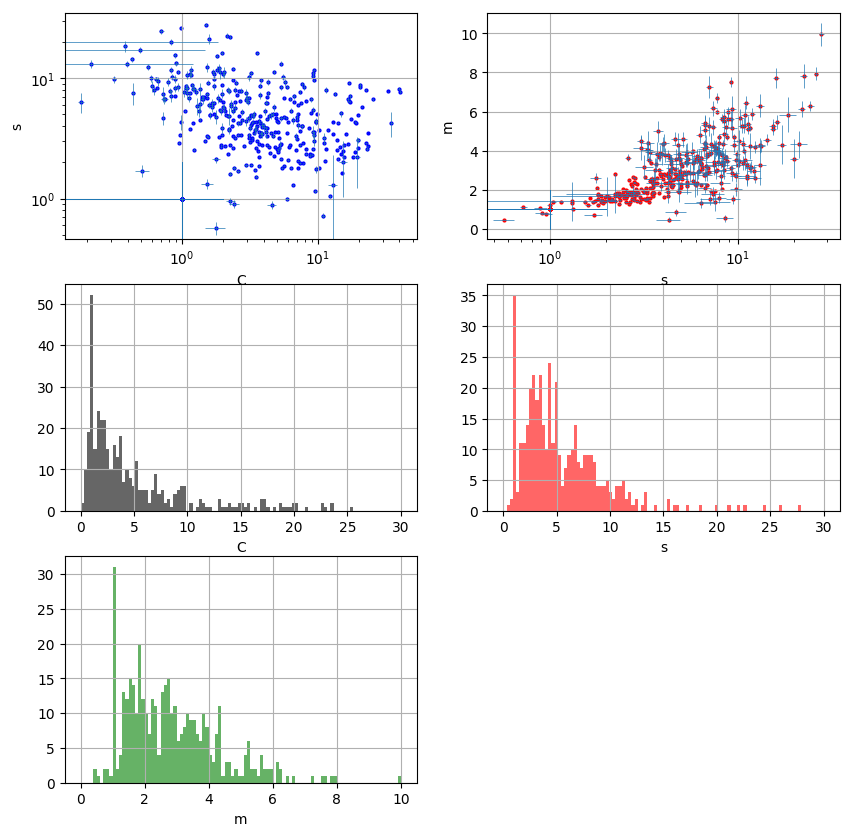

In [3]:
csvfile= "test-fitCauchy-dummy.csv"
df= CSV.read(csvfile , delim= ";")


fig= PyPlot.figure(figsize=(10,10))

ax= PyPlot.subplot(321)
PyPlot.grid("on")
ax.set_xscale("log")
ax.set_yscale("log")
PyPlot.xlabel("C")
PyPlot.ylabel("s")
PyPlot.scatter(df.C, df.s , s=4, facecolor="blue" )
PyPlot.errorbar(df.C, df.s, xerr=df.Cerr, yerr=df.serr, linewidth=0.5,ls="none")


ax= PyPlot.subplot(322)
PyPlot.grid("on")
ax.set_xscale("log")
#ax.set_yscale("log")
PyPlot.xlabel("s")
PyPlot.ylabel("m")
PyPlot.scatter(df.s, df.m , s=4, facecolor="red" )
PyPlot.errorbar(df.s, df.m, xerr=df.serr, yerr=df.merr, linewidth=0.5,ls="none")

ax = PyPlot.subplot(323)
PyPlot.grid("on")
nbins = 100
h = PyPlot.hist(df.C,nbins,range = [0,30], color = "k", alpha=0.6 , label = "C")
PyPlot.xlabel("C")

ax = PyPlot.subplot(324)
PyPlot.grid("on")
nbins = 100
h = PyPlot.hist(df.s,nbins,range = [0,30], color = "r", alpha=0.6 , label = "s")
PyPlot.xlabel("s")

ax = PyPlot.subplot(325)
PyPlot.grid("on")
nbins = 100
h = PyPlot.hist(df.m,nbins,range = [0,10], color = "g", alpha=0.6 , label = "s")
PyPlot.xlabel("m")

PyPlot.show()

--------------
## Checking all the fit with data.

Figs saved with data density with Cauchy Fit.

In [4]:
function _plotFitDensityFig(filelist, θlist, ifig, nrow, ncol, ocdir)
    
    fig= PyPlot.figure(figsize=(15,10))
    
    for i in 1:length(filelist)
        ocname= filelist[i][1:end-4]
        θ= θlist[i]
        ocfile= "$ocdir/$ocname-oc.csv"
        _plotDensity(ocfile, θ,nrow, ncol, i, ocname)
    end
    
    figname= "densityOC-$ifig.png"
    PyPlot.savefig(figname)
    PyPlot.close(fig)
end


function _plotDensity(ocfile, θ, irow, icol, nplot, title)
    oc= CSV.read(ocfile, delim= ";")
    # binned density
    nstar= length(oc.X)
    nbin= min(trunc(Int, nstar/10),20)
    r2d,ρ2d,err2d= density2D(oc.Y, oc.Z, nbin)
    ρ2dfit= model_rad(r2d, θ, fdens1)
    
    ax= PyPlot.subplot(irow, icol, nplot)
    ax.set_xlabel("r [pc]")
    ax.set_ylabel("ρ")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlim(r2d[1]*0.9, r2d[end]*1.1)
    ax.set_ylim(minimum(ρ2d[ρ2d .> 0])*0.3,maximum(ρ2d)*1.5)
    PyPlot.grid("on")
    PyPlot.scatter(r2d, ρ2d , s=4, facecolor="blue" )
    PyPlot.errorbar(r2d, ρ2d, yerr=2 .* err2d, linewidth=0.5)
    PyPlot.plot(r2d, ρ2dfit, "k-", linewidth=1)
    
    ## TEXT
    ax.text(0.02, 0.01, title, verticalalignment= "bottom" , horizontalalignment="left",
        transform=ax.transAxes, color="green", fontsize=15)
    
    val=θ.C ; txt= @sprintf("C= %3.3f",val)
    ax.text(0.02, 0.2, txt, verticalalignment= "bottom" , horizontalalignment="left",
        transform=ax.transAxes, color="red", fontsize=12)
    val=θ.s ; txt= @sprintf("s= %3.3f [pc]",val)
    ax.text(0.02, 0.3, txt, verticalalignment= "bottom" , horizontalalignment="left",
        transform=ax.transAxes, color="red", fontsize=12) 
    val=θ.m ; txt= @sprintf("m= %3.3f",val)
    ax.text(0.02, 0.4, txt, verticalalignment= "bottom" , horizontalalignment="left",
        transform=ax.transAxes, color="red", fontsize=12)
    
    val= nstar ; txt= @sprintf("Nstar= %d",val)
    ax.text(0.02, 0.52, txt, verticalalignment= "bottom" , horizontalalignment="left",
        transform=ax.transAxes, color="blue", fontsize=12)
    
end

_plotDensity (generic function with 1 method)

In [5]:
cd(plotdir)

rowperfig= 4
colperfig= 3
plotperfig= rowperfig*colperfig

ifig= 1
plotaccum=0
filevot= [] ; θlist= [] ; θerrlist= []
for item in 1:length(df.voname)
    push!(filevot, df.voname[item])
    θ= GaiaClustering.modelCauchy(df.C[item], df.s[item], df.m[item])
    push!(θlist, θ)
    θerr= GaiaClustering.modelCauchy(df.Cerr[item], df.serr[item], df.merr[item])
    push!(θerrlist, θerr)
    plotaccum += 1
    
    if plotaccum == plotperfig
        _plotFitDensityFig(filevot, θlist, ifig,rowperfig, colperfig , ocdir)
        println("## Fig $ifig done.")
        filevot= [] ; θlist= [] ; θerrlist= []
        plotaccum= 0 ; ifig += 1

    end
end

cd(wdir)

## Fig 1 done.
## Fig 2 done.
## Fig 3 done.
## Fig 4 done.
## Fig 5 done.
## Fig 6 done.
## Fig 7 done.
## Fig 8 done.
## Fig 9 done.
## Fig 10 done.
## Fig 11 done.
## Fig 12 done.
## Fig 13 done.
## Fig 14 done.
## Fig 15 done.
## Fig 16 done.
## Fig 17 done.
## Fig 18 done.
## Fig 19 done.
## Fig 20 done.
## Fig 21 done.
## Fig 22 done.
## Fig 23 done.
## Fig 24 done.
## Fig 25 done.
## Fig 26 done.
## Fig 27 done.
## Fig 28 done.
## Fig 29 done.
## Fig 30 done.
## Fig 31 done.
## Fig 32 done.
## Fig 33 done.
